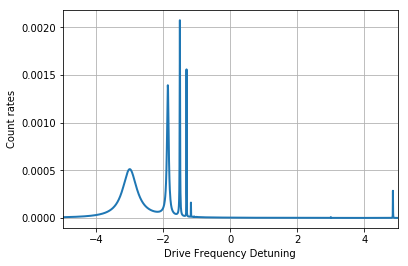

In [4]:
#
# Steady-state density matrix of a two-level atom in a high-Q
# cavity for various driving frequencies calculated using
# iterative 'steady' solver.
#
# Adapted from 'probss' example in the as functions of the detuning $\Delta_c$.
#
from qutip import *
from pylab import *
import scipy

def probss(E, kappa, gamma1, gamma2, gamma12, g, wc, w31, w32, w1, wl, N, Omega):
    # construct composite operators
    ida = qeye(N)
    idatom = qeye(3)
    sig13 = Qobj([[0, 0, 1],[0, 0, 0],[0, 0, 0]])
    sig31 = Qobj([[0, 0, 0],[0, 0, 0],[1, 0, 0]])
    sig23 = Qobj([[0, 0, 0],[0, 0, 1],[0, 0, 0]])
    sig32 = Qobj([[0, 0, 0],[0, 0, 0],[0, 1, 0]])
    sig12 = Qobj([[0, 1, 0],[0, 0, 0],[0, 0, 0]])
    sig21 = Qobj([[0, 0, 0],[1, 0, 0],[0, 0, 0]])
    sig33 = Qobj([[0, 0, 0],[0, 0, 0],[0, 0, 1]])
    sig22 = Qobj([[0, 0, 0],[0, 1, 0],[0, 0, 0]])
    
    a = tensor(destroy(N), idatom)
    s13 = tensor(ida, sig13)
    s31 = tensor(ida, sig31)
    s23 = tensor(ida, sig23)
    s32 = tensor(ida, sig32)
    s12 = tensor(ida, sig12)
    s21 = tensor(ida, sig21)
    s22 = tensor(ida, sig22)
    s33 = tensor(ida, sig33)
    
    # Hamiltonian
    H = (wl - wl + 3) * s31*s13 + (wl - wl - w32 + w1 + 3) * s23*s32 + (wc - wl) * a.dag() * a + \
        g * (a.dag()*s13  +  a*s31) + Omega * (s23 + s32) + E * (a.dag() + a) # E*(s31+s13) #

    # Collapse operators
    C1 = sqrt(2 * kappa) * a
    C2 = sqrt(2 * gamma1) * s13
    C3 = sqrt(2 * gamma2) * s32
    C4 = sqrt(2 * gamma12) * s12
    C1dC1 = C1.dag() * C1
    C2dC2 = C2.dag() * C2
    C3dC3 = C3.dag() * C3
    #C4dC4 = C4.dag() * C4

    #method	‘direct’, ‘eigen’, ‘power’, ‘iterative-gmres’,’iterative-lgmres’, ‘svd’
    
    # find steady state
    rhoss = steadystate(H, [C1, C2, C3, C4],use_precond=True, method='eigen',sparse=False,use_rcm = True, use_wbm=True,tol=1e-6)

    # calculate expectation values
    a_dag_a_e = expect(C1dC1, rhoss)
    s33_e = expect(C2dC2, rhoss)
    s22_e = expect(C3dC3, rhoss)
    s13_e = expect(s13,rhoss)
    s23_e = expect(s23,rhoss)
    s13_a_e = expect(a.dag()*s13,rhoss)
    s23_e = expect(s23,rhoss)
    a_e = expect(a, rhoss)

    return a_dag_a_e, s33_e, s22_e, s13_e, s23_e, s13_a_e, s23_e, a_e


# setup the calculation
#-----------------------
# must be done before parfunc unless we
# want to pass all variables as one using
# zip function (see documentation for an example)
kappa = 0.001
gamma1 = 0.001
gamma2 = 0.001
gamma12 =0.0
Omega = 0.05
g = 3.0
wc = 0.0
w31 = 0.0
w32 = 0.0
w1 = 0.0
N =30
E = 0.128

nloop = 2000
wl = linspace(-7,5,nloop)

# define single-variable function for use in parfor
# cannot be defined inside run() since it needs to
# be passed into seperate threads.
def parfunc(wl):  # function of wl only
    a_dag_a_e, s33_e, s22_e, s13_e, s23_e, s13_a_e, s23_e, a_e = probss(E, kappa, gamma1, gamma2, gamma12, g, wc, w31, w32, w1, wl, N, Omega)
    return a_dag_a_e, s33_e, s22_e, s13_e, s23_e, s13_a_e, s23_e, a_e

def run():
    # run parallel for-loop over wlist
    a_dag_a_e, s33_e, s22_e, s13_e, s23_e, s13_a_e, s23_e, a_e = parfor(parfunc, wl)
    
   # output_data=vstack((wlist,real(count1), imag(count1),real(count2), imag(count2),real(count3),imag(count3),real(sma),imag(sma), real(infield),imag(infield)))
    output_data=vstack((wl,real(a_dag_a_e),real(s33_e),real(s22_e), real(s13_e), imag(s13_e),real(s23_e), imag(s23_e),real(s13_a_e), imag(s13_a_e),real(s23_e), imag(s23_e), real(a_e),imag(a_e)))
    file_data_store('/home/photon/Dropbox/data/three_level_single_mode/quantum_spectra/full_spectrum/g_3_Omeg_0_00_k_0_001_gam1_0_001_gam2_0_001_gam12_0_0_E_0_128_vertical_scan_shifted_down_3a.dat',output_data.T,numtype="real",sep=",")
    
    # plot cavity emission and qubit spontaneous emssion
    fig = figure(1)
    ax = fig.add_subplot(111)
    #ax.plot(wlist, real(a_dag_a_e), lw=2)
    ax.plot(wl, real(a_dag_a_e),lw=2)
    xlabel('Drive Frequency Detuning')
    ylabel('Count rates')
    xlim(-5,5)
    ax.grid()
    show()


if __name__ == "__main__":
   run()

In [ ]:
## output_data=vstack((wlist,real(count1),imag(count1),real(infield),imag(infield),real(sma), imag(sma),real(spa), imag(spa)))
file_data_store('/photon/Documents/manuscripts/data/three_level_strong_cavity/quantum_model/spa_sma.dat',output_data.T,numtype="real",sep=",")

In [ ]:
#import qutip.testing as qt
#qt.run()

In [ ]:
.dat',output_data.T,numtype="real",sep=",")
    sig13=tensor(basis(3,0), basis(3,2).dag())

In [ ]:
basis(3,0)
ida
idatom
#sig13

In [ ]:
sig13=Qobj([[0,0,1],[0,0,0],[0,0,0]])
sig23=Qobj([[0,0,0],[0,0,1],[0,0,0]])
sig12 = Qobj([[0,1,0],[0,0,0],[0,0,0]])

In [ ]:
print(sig12)